In [1]:
import os
import glob
import cv2
import time
import copy
import pickle  # Log dictionary data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn.metrics as metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # stateless functions
import torchvision.transforms as T
import torchvision.models as models

import multiprocessing
# We must import this explicitly, it is not imported by the top-level
# multiprocessing module.
import multiprocessing.pool

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from datetime import datetime
from multiprocessing import Manager
from PIL import Image

import glob
import cv2
import time
import copy
import pickle  # Log dictionary data
import skimage.io
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn.metrics as metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # stateless functions
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from PIL import Image

In [21]:
"""Configuration in Common
    To resolve the CUDA out of memory issue, we can trade-off between number of tiles and batch_size
"""
class CFG:
    debug = False
    device = torch.device('cuda')
    dtype = torch.float32
    nfolds = 4
    n_tile = 12
    seed = 524
    TRAIN = '../yi_data/panda-16x128x128-tiles-data/train/'
    LABELS = '../data/train.csv'

"""Configuration for Stage One
"""
class CFG1:
    batch_size = 10
    epochs = 16
    lr = 1e-4
    model_name = 'resnet_bc'
    num_classes = 1
    nworkers = 1
    threshold = .277
    
"""Configuration for Stage Two
"""
class CFG2:
    batch_size = 10
    epochs = 20
    lr = 1e-4
    model_name = 'resnet_head'
    num_classes = 3
    nworkers = 1

# Datasets and Dataloader

In [3]:
train = pd.read_csv(CFG.LABELS).set_index('image_id')
files = sorted(set([p[:32] for p in os.listdir(CFG.TRAIN)]))
train = train.loc[files].reset_index()

if CFG.debug:
    df = train.sample(n=50, random_state=CFG.seed).copy().reset_index(drop=True)
else:
    df = train.copy()

# Generate train/validation sets containing the same distribution of isup_grade
splits = StratifiedKFold(n_splits=CFG.nfolds, random_state=CFG.seed, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
# Assign split index to training samples
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(CFG.nfolds):
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df.head()

,image_id,data_provider,isup_grade,gleason_score,split
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,2
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,3
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0


In [4]:
# https://www.kaggle.com/yasufuminakama/panda-se-resnext50-regression-baseline
class TrainDataset(Dataset):
    """Prostate Cancer Biopsy Dataset"""
    
    def __init__(self, df, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            root_dir (string): Path to the directory with all images
            transform (callable, optional): Optional transform to be applied on an image sample
        """
        # Shuffle dataframes with fixed seed; otherwise, validation set only get cancerous samples
        self.df = df
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python
        tile_fns = [f"{CFG.TRAIN}/{self.df['image_id'][idx]}_{sub_id}.png" for sub_id in range(CFG.n_tile)]
        # As we use cv2, the color channel is BGR. https://stackoverflow.com/questions/50963283/python-opencv-imshow-doesnt-need-convert-from-bgr-to-rgb
        img_tiles = [Image.fromarray(cv2.imread(fn)) for fn in tile_fns]
        if self.transform:
            img_tiles = list(map(self.transform, img_tiles))
        
        label = self.labels[idx]

        return img_tiles, label

In [5]:
def get_transforms(phase):
    assert phase in {'train', 'val'}
    
    if phase == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(15, fill=255),
            T.ToTensor(),
            T.Normalize(
                mean=[0.8525, 0.7810, 0.8907],
                std=[0.1723, 0.2614, 0.1419],
            ),
        ])
    else:
        return T.Compose([
            T.ToTensor(),
            T.Normalize(
                mean=[0.8525, 0.7810, 0.8907],
                std=[0.1723, 0.2614, 0.1419],
            ),
        ])

In [6]:
"""
transform = get_transforms(phase='train')
train_dataset = TrainDataset(df.reset_index(drop=True),
                             df.reset_index(drop=True)['isup_grade'],
                             transform = get_transforms(phase='train'))
img, label = train_dataset[0]
#tiles = map(transform, tiles)
#print(list(tiles))
#print(label)
#print(tiles.shape)
#print(type(tiles[0]))
plt.imshow(img.permute(1,2,0))
#plt.show()
#plt.imshow(tiles[0].permute(1,2,0))
"""

"\ntransform = get_transforms(phase='train')\ntrain_dataset = TrainDataset(df.reset_index(drop=True),\n                             df.reset_index(drop=True)['isup_grade'],\n                             transform = get_transforms(phase='train'))\nimg, label = train_dataset[0]\n#tiles = map(transform, tiles)\n#print(list(tiles))\n#print(label)\n#print(tiles.shape)\n#print(type(tiles[0]))\nplt.imshow(img.permute(1,2,0))\n#plt.show()\n#plt.imshow(tiles[0].permute(1,2,0))\n"

In [6]:
# Use fold idx as validation set
def data_loader_stage1(fold_idx):
    train_idx = df[df['split'] != fold_idx].index
    val_idx = df[df['split'] == fold_idx].index

    train_dataset = TrainDataset(df.loc[train_idx].reset_index(drop=True),
                                 df.loc[train_idx].reset_index(drop=True)['isup_grade'],
                                 transform = get_transforms(phase='train'))
    val_dataset = TrainDataset(df.loc[val_idx].reset_index(drop=True),
                               df.loc[val_idx].reset_index(drop=True)['isup_grade'],
                               transform = get_transforms(phase='val'))
    
    train_loader = DataLoader(train_dataset, batch_size=CFG1.batch_size, shuffle=True, num_workers=CFG1.nworkers)
    val_loader = DataLoader(val_dataset, batch_size=CFG1.batch_size, shuffle=False, num_workers=CFG1.nworkers)
    return train_loader, val_loader

def data_loader_stage2(fold_idx):
    train_idx = df[(df['split'] != fold_idx) & (df['isup_grade'] > 2)].index
    val_idx = df[(df['split'] == fold_idx) & (df['isup_grade'] > 2)].index

    train_dataset = TrainDataset(df.loc[train_idx].reset_index(drop=True),
                                 df.loc[train_idx].reset_index(drop=True)['isup_grade']-3,
                                 transform = get_transforms(phase='train'))
    val_dataset = TrainDataset(df.loc[val_idx].reset_index(drop=True),
                               df.loc[val_idx].reset_index(drop=True)['isup_grade']-3,
                               transform = get_transforms(phase='val'))
    
    train_loader = DataLoader(train_dataset, batch_size=CFG2.batch_size, shuffle=True, num_workers=CFG2.nworkers)
    val_loader = DataLoader(val_dataset, batch_size=CFG2.batch_size, shuffle=False, num_workers=CFG2.nworkers)
    return train_loader, val_loader

# Training

In [8]:
def train_model(stage, model, fold, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # Send the model to GPU/CPU
    model = model.to(device=CFG.device)
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            preds, targets = [], []

            if phase == 'train':
                model.train()   # Set model to training phase
            else:
                model.eval()    # Set model to evaluate phase
            
            avg_loss = 0.0
            running_corrects = 0
            
            print(' ', end='', flush=True)  # To workaround tqdm issue in multiprocess
            for inputs, labels in tqdm(dataloaders[phase],
                                       desc='[{}-{}] {}/{}({:5s})'.format(stage, fold, epoch+1,num_epochs,phase)):
                _, C, H, W = inputs[0].shape
                # n_tile[(bs,3,128,128)]-->(bs,n_tile,3,128,128)-->(bs*n_tile,3,128,128)
                inputs = torch.stack(inputs, 1).view(-1,C,H,W).to(device=CFG.device, dtype=CFG.dtype)
                if stage == 1:
                    labels = torch.where(labels<3, torch.tensor(0), torch.tensor(1)).to(device=CFG.device, dtype=CFG.dtype)
                elif stage == 2:
                    labels = labels.to(device=CFG.device, dtype=torch.long)
                else:
                    assert False
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward, track history if only in training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).squeeze(1)
                    #print(outputs.shape, labels.shape)
                    loss = criterion(outputs, labels)
                    #print(outputs)
                    if stage == 1:
                        pred = torch.where(outputs<CFG1.threshold,
                                           torch.tensor(0).to(device=CFG.device),
                                           torch.tensor(1).to(device=CFG.device)).to(device=CFG.device, dtype=torch.long)
                        labels = labels.to(dtype=torch.long)
                    #print(pred)
                    #print(labels)
                    elif stage == 2:
                        pred = torch.argmax(outputs, 1)
                        #print(type(pred))
                        #print(pred.shape)
                    else:
                        assert False

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                avg_loss += loss.item()*(inputs.size(0)/len(dataloaders[phase].dataset))  # len(dataloaders[phase].dataset) not len(dataloaders[phase])
                running_corrects += torch.sum(pred == labels)
                #print('correts: ', torch.sum(pred == labels))
                preds.append(pred)
                targets.append(labels)
            
            # End of epoch
            with torch.no_grad():
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                if phase == 'val':
                    val_acc_history.append(epoch_acc)
                    # deep copy the model
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                    # Apply lr_scheduler
                    if scheduler is not None:
                        scheduler.step(avg_loss)
                else:
                    train_acc_history.append(epoch_acc)
                    loss_history.append(avg_loss)
                print('[{}-{}] {} Loss: {:4f} Acc: {:4f}'.format(stage, fold, phase, avg_loss, epoch_acc))
    
    time_elapsed = time.time() - since
    print('[{}-{}] Training complete in {:.0f}m {:0f}s'.format(stage, fold, time_elapsed//60, time_elapsed%60))
    print('[{}-{}] Best val Acc: {:4f}'.format(stage, fold, best_acc))
    print()
    
    model.load_state_dict(best_model_wts)
    return model, loss_history, train_acc_history, val_acc_history

## Two-Stage Classifier

In [7]:
"""Customize Resnet Header"""
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=1):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        self.output_size = sz
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

# https://www.kaggle.com/nelsongriffiths/mish-activation-and-transfer-learning-pytorch
def mish(x):
    return (x*torch.tanh(F.softplus(x)))

class mish_layer(nn.Module):
    def __init__(self):
        super(mish_layer, self).__init__()
        
    def forward(self, input):
        return mish(input)

class CustomResnetBC(nn.Module):
    def __init__(self, n=1):
        super().__init__()
        self.enc = nn.Sequential(*list(models.resnet18(pretrained=False).children())[:-2])
        num_ftrs= models.resnet18().fc.in_features
        self.head = nn.Sequential(
                        nn.AdaptiveAvgPool2d((1,1)),
                        nn.Flatten(),
                        nn.Linear(num_ftrs, n),
                        nn.Sigmoid())
        
    def forward(self, x):
        n_tile = CFG.n_tile
        enc_out = self.enc(x)
        _, C, H, W = enc_out.shape
        # (bs,n_tile,512,4,4)-->(bs,512,n_tile,4,4)-->(bs,512,n_tile*4,4)
        head_in = enc_out.view(-1,n_tile,C,H,W).permute(0,2,1,3,4)\
                  .contiguous().view(-1,C,n_tile*H,W)
        head_out = self.head(head_in)
        
        return head_out
    
class CustomResnet(nn.Module):
    def __init__(self, n=6):
        super().__init__()
        self.enc = nn.Sequential(*list(models.resnet18(pretrained=False).children())[:-2])
        num_ftrs= models.resnet18().fc.in_features
        self.head = nn.Sequential(
                        AdaptiveConcatPool2d(),
                        nn.Flatten(),
                        nn.Linear(num_ftrs*2,512),
                        mish_layer(),
                        nn.BatchNorm1d(512),
                        nn.Dropout(0.5),
                        nn.Linear(512, n)
                    )
        
    def forward(self, x):
        n_tile = CFG.n_tile
        enc_out = self.enc(x)
        _, C, H, W = enc_out.shape
        # (bs,n_tile,512,4,4)-->(bs,512,n_tile,4,4)-->(bs,512,n_tile*4,4)
        head_in = enc_out.view(-1,n_tile,C,H,W).permute(0,2,1,3,4)\
                  .contiguous().view(-1,C,n_tile*H,W)
        head_out = self.head(head_in)
        
        return head_out

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

def initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False):
    """
    Params:
        feature_extract
            True - fine tunning
            False - fix the model
    """
    model_ft = None
    
    if model_name == 'alexnet':
        """AlexNet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet':
        """Resnet
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet_bc':
        """Resnet
        """
        model_ft = CustomResnetBC(num_classes)
    elif model_name == 'resnet_head':
        """Restnet with customized header
        """
        model_ft = CustomResnet(num_classes)
    return model_ft


def train_stage1_layer(fold):
    model_ft = initialize_model(CFG1.model_name, CFG1.num_classes, use_pretrained=False)

    optimizer = optim.Adam(model_ft.parameters(),
                           lr=CFG1.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, eps=1e-06)
    loader_train, loader_val = data_loader_stage1(fold)
    return train_model(1, model_ft, fold,
                       {'train': loader_train, 'val': loader_val},
                       nn.BCELoss(), optimizer, scheduler, CFG1.epochs)

def train_stage2_layer(fold):
    model_ft = initialize_model(CFG2.model_name, CFG2.num_classes, use_pretrained=False)
    optimizer = optim.Adam(model_ft.parameters(),
                           lr=CFG2.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, eps=1e-06)
    loader_train, loader_val = data_loader_stage2(fold)
    return train_model(2, model_ft, fold,
                      {'train': loader_train, 'val': loader_val},
                      F.cross_entropy, optimizer, scheduler, CFG2.epochs)

## Multiprocessing

In [11]:
class NoDaemonProcess(multiprocessing.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class MyPool(multiprocessing.pool.Pool):
    Process = NoDaemonProcess

def progressor(fold):
    #print(f'stage{stage} fold{fold}')
    best_model_1, loss_history_1, train_acc_history_1, val_acc_history_1 = train_stage1_layer(fold)
    best_model_2, loss_history_2, train_acc_history_2, val_acc_history_2 = train_stage2_layer(fold)
    return {f'stage1_model_{fold}': best_model_1.to('cpu'),  # Don't save model as cuda
            f'stage1_loss_history_{fold}': loss_history_1,
            f'stage1_train_acc_history_{fold}': train_acc_history_1,
            f'stage1_val_acc_history_{fold}': val_acc_history_1,
            f'stage2_model_{fold}': best_model_2.to('cpu'),  # Don't save model as cuda
            f'stage2_loss_history_{fold}': loss_history_2,
            f'stage2_train_acc_history_{fold}': train_acc_history_2,
            f'stage2_val_acc_history_{fold}': val_acc_history_2}

## Start Training

In [12]:
log_dict = {'batch_size_1': CFG1.batch_size,
            'batch_size_2': CFG2.batch_size,
            'epochs_1': CFG1.epochs,
            'epochs_2': CFG2.epochs,
            'learning_rate_1': CFG1.lr,
            'learning_rate_2': CFG2.lr,
            'model_1': CFG1.model_name,
            'model_2': CFG2.model_name,
            'nworkers_1': CFG1.nworkers,
            'nworkers_2': CFG2.nworkers,
            'nfolds': CFG.nfolds,
            'random_seed': CFG.seed}

result_list = list(MyPool(CFG.nfolds).map(progressor, range(CFG.nfolds)))

# Accumulate result from each process
for result in result_list:
    log_dict.update(result)


[1-0] train Loss: 6.653235 Acc: 0.669583
 


[1-3] train Loss: 6.622732 Acc: 0.675035
 


[1-2] train Loss: 6.576290 Acc: 0.695448
 
[1-1] train Loss: 6.589874 Acc: 0.680360
 


[1-0] val Loss: 5.920594 Acc: 0.713199
 
[1-3] val Loss: 6.785075 Acc: 0.637505
 


[1-1] val Loss: 6.045399 Acc: 0.761506
 


[1-2] val Loss: 5.726179 Acc: 0.691518
 


[1-0] train Loss: 5.963226 Acc: 0.722455
 


[1-3] train Loss: 6.056080 Acc: 0.719158
 


[1-1] train Loss: 5.993843 Acc: 0.716622
 


[1-2] train Loss: 6.011035 Acc: 0.719665
 


[1-3] val Loss: 5.800119 Acc: 0.779764
 


[1-0] val Loss: 5.923573 Acc: 0.767592
 


[1-1] val Loss: 5.578070 Acc: 0.764549
 


[1-2] val Loss: 5.450935 Acc: 0.739825
 


[1-3] train Loss: 5.758503 Acc: 0.737796
 


[1-0] train Loss: 5.744821 Acc: 0.739064
 


[1-1] train Loss: 5.757226 Acc: 0.740713
 


[1-2] train Loss: 5.797607 Acc: 0.738557
 



[1-0] val Loss: 7.260635 Acc: 0.628376
 [1-3] val Loss: 5.644066 Acc: 0.716242
 


[1-2] val Loss: 5.563382 Acc: 0.759224
 


[1-1] val Loss: 5.336773 Acc: 0.739825
 


[1-0] train Loss: 5.668295 Acc: 0.749968
 


[1-3] train Loss: 5.675446 Acc: 0.744009
 


[1-2] train Loss: 5.637107 Acc: 0.747179
 


[1-1] train Loss: 5.596136 Acc: 0.749968
 


[1-3] val Loss: 5.485266 Acc: 0.750095
 


[1-0] val Loss: 5.396438 Acc: 0.728033
 


[1-1] val Loss: 5.266058 Acc: 0.806771
 


[1-2] val Loss: 6.091935 Acc: 0.775960
 


[1-3] train Loss: 5.575218 Acc: 0.751490
 


[1-0] train Loss: 5.471614 Acc: 0.759985
 


[1-2] train Loss: 5.516075 Acc: 0.754152
 


[1-1] train Loss: 5.543023 Acc: 0.759224
 


[1-3] val Loss: 7.561888 Acc: 0.766451
 


[1-0] val Loss: 5.420646 Acc: 0.806771
 


[1-1] val Loss: 5.259754 Acc: 0.805249
 


Epoch     5: reducing learning rate of group 0 to 1.0000e-05.
[1-2] val Loss: 5.733669 Acc: 0.693420
 


[1-3] train Loss: 5.415084 Acc: 0.757449
 


[1-0] train Loss: 5.498486 Acc: 0.758844
 


[1-1] train Loss: 5.403739 Acc: 0.763789
 


[1-2] train Loss: 5.236077 Acc: 0.770762
 


[1-3] val Loss: 5.218969 Acc: 0.758844
 


[1-0] val Loss: 7.260161 Acc: 0.770255
 


[1-2] val Loss: 4.911654 Acc: 0.795740
 


[1-1] val Loss: 5.781874 Acc: 0.704450
 


[1-3] train Loss: 5.396143 Acc: 0.761887
 


[1-0] train Loss: 5.425974 Acc: 0.763281
 


[1-2] train Loss: 5.118134 Acc: 0.783061
 


[1-1] train Loss: 5.352233 Acc: 0.767592
 


[1-3] val Loss: 5.602006 Acc: 0.701788
 


[1-0] val Loss: 5.351816 Acc: 0.792316
 


[1-2] val Loss: 4.884766 Acc: 0.774439
 


[1-1] val Loss: 5.339884 Acc: 0.790034
 


[1-3] train Loss: 5.295121 Acc: 0.766958
 


[1-0] train Loss: 5.326667 Acc: 0.776087
 


[1-2] train Loss: 5.065554 Acc: 0.782554
 


[1-1] train Loss: 5.357551 Acc: 0.773171
 


[1-3] val Loss: 5.207185 Acc: 0.791175
 


[1-0] val Loss: 5.120752 Acc: 0.799924
 


Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
[1-1] val Loss: 5.806123 Acc: 0.726512
 


[1-2] val Loss: 4.883396 Acc: 0.777482
 


[1-3] train Loss: 5.188158 Acc: 0.775200
 


[1-0] train Loss: 5.283174 Acc: 0.773044
 


[1-1] train Loss: 5.051650 Acc: 0.785470
 


[1-2] train Loss: 5.034788 Acc: 0.782934
 


[1-3] val Loss: 6.783171 Acc: 0.655382
 


[1-0] val Loss: 5.221563 Acc: 0.725371
 


[1-2] val Loss: 4.881723 Acc: 0.782046
 


[1-1] val Loss: 4.828231 Acc: 0.785470
 


[1-3] train Loss: 5.191457 Acc: 0.774312
 


[1-0] train Loss: 5.195715 Acc: 0.779891
 


[1-2] train Loss: 5.017560 Acc: 0.783441
 


[1-1] train Loss: 4.872187 Acc: 0.796374
 


[1-3] val Loss: 5.746843 Acc: 0.805630
 


[1-2] val Loss: 4.823245 Acc: 0.794979
 


[1-0] val Loss: 5.030559 Acc: 0.780905
 


[1-1] val Loss: 4.829519 Acc: 0.793838
 


[1-3] train Loss: 5.097981 Acc: 0.781539
 


[1-2] train Loss: 4.962723 Acc: 0.784329
 


[1-0] train Loss: 5.142166 Acc: 0.781159
 


[1-1] train Loss: 4.854287 Acc: 0.799036
 


[1-3] val Loss: 5.140281 Acc: 0.764169
 


[1-2] val Loss: 4.851021 Acc: 0.771396
 


[1-0] val Loss: 5.327622 Acc: 0.804869
 


[1-1] val Loss: 4.820541 Acc: 0.775200
 


[1-3] train Loss: 5.109703 Acc: 0.779003
 


[1-2] train Loss: 4.880950 Acc: 0.791683
 


[1-0] train Loss: 5.125495 Acc: 0.785723
 


[1-1] train Loss: 4.759995 Acc: 0.803474
 


[1-3] val Loss: 4.982276 Acc: 0.763028
 


[1-2] val Loss: 4.819442 Acc: 0.799163
 


[1-0] val Loss: 5.107361 Acc: 0.768733
 


[1-1] val Loss: 4.804735 Acc: 0.800685
 


[1-3] train Loss: 5.057001 Acc: 0.786104
 


[1-2] train Loss: 4.875217 Acc: 0.793458
 


[1-0] train Loss: 5.083959 Acc: 0.784963
 


[1-1] train Loss: 4.807754 Acc: 0.798783
 


[1-3] val Loss: 4.965983 Acc: 0.804108
 


[1-2] val Loss: 4.811479 Acc: 0.805630
 


Epoch    13: reducing learning rate of group 0 to 1.0000e-05.
[1-0] val Loss: 5.949745 Acc: 0.793838
 


[1-1] val Loss: 4.805304 Acc: 0.779764
 


[1-3] train Loss: 4.966023 Acc: 0.792697
 


[1-2] train Loss: 4.840131 Acc: 0.795613
 


[1-0] train Loss: 4.804376 Acc: 0.801699
 


[1-1] train Loss: 4.754606 Acc: 0.803854
 


[1-3] val Loss: 4.991012 Acc: 0.780145
 


[1-2] val Loss: 4.796693 Acc: 0.790034
 


[1-0] val Loss: 4.729654 Acc: 0.799924
 


[1-1] val Loss: 4.770657 Acc: 0.783948
 


[1-3] train Loss: 4.937118 Acc: 0.795233
 


[1-2] train Loss: 4.825207 Acc: 0.796120
 


[1-0] train Loss: 4.647443 Acc: 0.808926
 


[1-1] train Loss: 4.752749 Acc: 0.807024
 


[1-3] val Loss: 5.856157 Acc: 0.659186
 


[1-2] val Loss: 4.917642 Acc: 0.775200
 


[1-0] val Loss: 4.697701 Acc: 0.807912
 


[1-1] val Loss: 4.756163 Acc: 0.796501
 


[1-3] train Loss: 4.937771 Acc: 0.792570
 


[1-2] train Loss: 4.816314 Acc: 0.800178
 


[1-0] train Loss: 4.662544 Acc: 0.811589
 


[1-1] train Loss: 4.710336 Acc: 0.804742
 


Epoch    16: reducing learning rate of group 0 to 1.0000e-05.
[1-3] val Loss: 5.009396 Acc: 0.807151
[1-3] Training complete in 429m 1.939955s
[1-3] Best val Acc: 0.807151

 


[1-2] val Loss: 4.855562 Acc: 0.791556
[1-2] Training complete in 429m 46.731620s
[1-2] Best val Acc: 0.805630


[1-0] val Loss: 4.693427 Acc: 0.804869
[1-0] Training complete in 429m 47.130433s
[1-0] Best val Acc: 0.807912


[1-1] val Loss: 4.769714 Acc: 0.811715
[1-1] Training complete in 429m 48.068607s
[1-1] Best val Acc: 0.811715

 


[2-3] train Loss: 14.352584 Acc: 0.370344
 


[2-3] val Loss: 13.562771 Acc: 0.375679
 


[2-2] train Loss: 14.374797 Acc: 0.367945
 


[2-0] train Loss: 14.312245 Acc: 0.376130
 


[2-1] train Loss: 14.396463 Acc: 0.363242
 


[2-2] val Loss: 13.331498 Acc: 0.393709
 


[2-0] val Loss: 13.287070 Acc: 0.389794
 


[2-1] val Loss: 13.044654 Acc: 0.393709
 


[2-3] train Loss: 13.988704 Acc: 0.391320
 


[2-3] val Loss: 12.952509 Acc: 0.409338
 


[2-2] train Loss: 14.238665 Acc: 0.365774
 


[2-0] train Loss: 14.179081 Acc: 0.365642
 


[2-1] train Loss: 14.246952 Acc: 0.372648
 


[2-2] val Loss: 13.091394 Acc: 0.417570
 


[2-0] val Loss: 13.311131 Acc: 0.385451
 


[2-1] val Loss: 13.120378 Acc: 0.416486
 


[2-3] train Loss: 13.863669 Acc: 0.387342
 


[2-3] val Loss: 12.828308 Acc: 0.428882
 


[2-2] train Loss: 13.740889 Acc: 0.384226
 


[2-0] train Loss: 13.652271 Acc: 0.413382
 


[2-1] train Loss: 14.029227 Acc: 0.390738
 


[2-2] val Loss: 12.912573 Acc: 0.442516
 


[2-1] val Loss: 12.873055 Acc: 0.418655
 
[2-0] val Loss: 12.897949 Acc: 0.432139
 


[2-3] train Loss: 13.752420 Acc: 0.409042
 


[2-3] val Loss: 12.920185 Acc: 0.401737
 


[2-2] train Loss: 13.731068 Acc: 0.401954
 


[2-1] train Loss: 13.965564 Acc: 0.392185
 


[2-0] train Loss: 13.516162 Acc: 0.394937
 


[2-2] val Loss: 12.920663 Acc: 0.430586
 


[2-1] val Loss: 12.707915 Acc: 0.473970
 


[2-0] val Loss: 13.185474 Acc: 0.423453
 


[2-3] train Loss: 13.531423 Acc: 0.424955
 


[2-3] val Loss: 13.151917 Acc: 0.419110
 


[2-2] train Loss: 13.495374 Acc: 0.417149
 


[2-1] train Loss: 13.526448 Acc: 0.415702
 


[2-0] train Loss: 13.544201 Acc: 0.416275
 


[2-2] val Loss: 13.119902 Acc: 0.422993
 


[2-1] val Loss: 13.069487 Acc: 0.446855
 


[2-0] val Loss: 12.870642 Acc: 0.407166
 


[2-3] train Loss: 13.295906 Acc: 0.431465
 


Epoch     6: reducing learning rate of group 0 to 1.0000e-05.
[2-3] val Loss: 13.532540 Acc: 0.433225
 


[2-2] train Loss: 13.343592 Acc: 0.407742
 


[2-1] train Loss: 13.463581 Acc: 0.420405
 


[2-0] train Loss: 13.275886 Acc: 0.423146
 


[2-2] val Loss: 12.876832 Acc: 0.420824
 


[2-1] val Loss: 13.626223 Acc: 0.396963
 


[2-0] val Loss: 12.755609 Acc: 0.445168
 


[2-3] train Loss: 13.334907 Acc: 0.433273
 


[2-3] val Loss: 12.514727 Acc: 0.447340
 


[2-2] train Loss: 13.260468 Acc: 0.429088
 


[2-1] train Loss: 13.388716 Acc: 0.430535
 


[2-0] train Loss: 13.353229 Acc: 0.429295
 


[2-2] val Loss: 13.122945 Acc: 0.401302
 


[2-1] val Loss: 12.503149 Acc: 0.454447
 


[2-0] val Loss: 12.956516 Acc: 0.432139
 


[2-3] train Loss: 13.070848 Acc: 0.440506
 


[2-3] val Loss: 12.505360 Acc: 0.440825
 


[2-2] train Loss: 13.183412 Acc: 0.444645
 


[2-1] train Loss: 13.198516 Acc: 0.420043
 


[2-0] train Loss: 13.032901 Acc: 0.430380
 


[2-2] val Loss: 12.426888 Acc: 0.467462
 


[2-1] val Loss: 13.032235 Acc: 0.440347
 


[2-0] val Loss: 13.187108 Acc: 0.413681
 


[2-3] train Loss: 12.875140 Acc: 0.453165
 


[2-3] val Loss: 12.350137 Acc: 0.461455
 


[2-2] train Loss: 13.041541 Acc: 0.440304
 


[2-1] train Loss: 13.164586 Acc: 0.434877
 


[2-0] train Loss: 13.086320 Acc: 0.427848
 


[2-2] val Loss: 12.625839 Acc: 0.484816
 


[2-1] val Loss: 12.764273 Acc: 0.481562
 


Epoch     9: reducing learning rate of group 0 to 1.0000e-05.
[2-0] val Loss: 12.773436 Acc: 0.451683
 


[2-3] train Loss: 12.682074 Acc: 0.462206
 


[2-3] val Loss: 12.374934 Acc: 0.470141
 


[2-2] train Loss: 12.915581 Acc: 0.447902
 


[2-1] train Loss: 13.052993 Acc: 0.432706
 


[2-0] train Loss: 12.455168 Acc: 0.474864
 


[2-2] val Loss: 12.855937 Acc: 0.457701
 


[2-1] val Loss: 12.268348 Acc: 0.484816
 


[2-0] val Loss: 12.321555 Acc: 0.479913
 


[2-3] train Loss: 12.953160 Acc: 0.449910
 


[2-3] val Loss: 12.331685 Acc: 0.480999
 


[2-2] train Loss: 12.891010 Acc: 0.455861
 


[2-1] train Loss: 12.905492 Acc: 0.436686
 


[2-0] train Loss: 12.489944 Acc: 0.477034
 


Epoch    11: reducing learning rate of group 0 to 1.0000e-05.
[2-2] val Loss: 12.920647 Acc: 0.454447
 


[2-1] val Loss: 12.460308 Acc: 0.464208
 


[2-0] val Loss: 12.393445 Acc: 0.480999
 


[2-3] train Loss: 12.828687 Acc: 0.466184
 


[2-3] val Loss: 12.243912 Acc: 0.488599
 


[2-2] train Loss: 12.537211 Acc: 0.465268
 


[2-1] train Loss: 12.886276 Acc: 0.443198
 


[2-0] train Loss: 12.322675 Acc: 0.484991
 


[2-2] val Loss: 12.090047 Acc: 0.506508
 


[2-1] val Loss: 12.691364 Acc: 0.478308
 


[2-0] val Loss: 12.301623 Acc: 0.479913
 


[2-3] train Loss: 12.535698 Acc: 0.478119
 


[2-3] val Loss: 12.198130 Acc: 0.492942
 


[2-2] train Loss: 12.451158 Acc: 0.471780
 


[2-1] train Loss: 12.583156 Acc: 0.475760
 


[2-0] train Loss: 12.320764 Acc: 0.495841
 


[2-2] val Loss: 11.956098 Acc: 0.514100
 


Epoch    13: reducing learning rate of group 0 to 1.0000e-05.
[2-1] val Loss: 12.422474 Acc: 0.486985
 


[2-0] val Loss: 12.236988 Acc: 0.488599
 


[2-3] train Loss: 12.648908 Acc: 0.468354
 


[2-3] val Loss: 12.192804 Acc: 0.479913
 


[2-2] train Loss: 12.073882 Acc: 0.504703
 


[2-1] train Loss: 12.296734 Acc: 0.488061
 


[2-0] train Loss: 12.197748 Acc: 0.505967
 


[2-2] val Loss: 12.094004 Acc: 0.496746
 


[2-1] val Loss: 11.678266 Acc: 0.537961
 


[2-0] val Loss: 12.610913 Acc: 0.480999
 


[2-3] train Loss: 12.534854 Acc: 0.477034
 


[2-3] val Loss: 12.340389 Acc: 0.488599
 


[2-2] train Loss: 12.315912 Acc: 0.492764
 


[2-1] train Loss: 12.181569 Acc: 0.494211
 


[2-0] train Loss: 12.153600 Acc: 0.513201
 


[2-2] val Loss: 11.922594 Acc: 0.497831
 


[2-1] val Loss: 11.638174 Acc: 0.531453
 


[2-0] val Loss: 12.232524 Acc: 0.497286
 


[2-3] train Loss: 12.527334 Acc: 0.480651
 


[2-3] val Loss: 12.151640 Acc: 0.490771
 


[2-2] train Loss: 12.022598 Acc: 0.493849
 


[2-1] train Loss: 12.131638 Acc: 0.505427
 


[2-0] train Loss: 12.185800 Acc: 0.501627
 


[2-2] val Loss: 12.022960 Acc: 0.516269
 


[2-1] val Loss: 11.620135 Acc: 0.534707
 


[2-0] val Loss: 12.126384 Acc: 0.497286
 


[2-3] train Loss: 12.377609 Acc: 0.494756
 


[2-3] val Loss: 12.317098 Acc: 0.488599
 


[2-2] train Loss: 12.030381 Acc: 0.518813
 


[2-1] train Loss: 12.192571 Acc: 0.503980
 


[2-0] train Loss: 12.121061 Acc: 0.482821
 


[2-2] val Loss: 11.870248 Acc: 0.502169
 


[2-1] val Loss: 11.612248 Acc: 0.534707
 


[2-0] val Loss: 12.232838 Acc: 0.483170
 


[2-3] train Loss: 12.245252 Acc: 0.508861
 


[2-3] val Loss: 12.124182 Acc: 0.500543
 


[2-2] train Loss: 12.009609 Acc: 0.515195
 


[2-1] train Loss: 12.091053 Acc: 0.499276
 


[2-0] train Loss: 12.099663 Acc: 0.488246
 


[2-2] val Loss: 11.944753 Acc: 0.515184
 


[2-1] val Loss: 11.612106 Acc: 0.528200
 


[2-0] val Loss: 12.478660 Acc: 0.480999
 


[2-3] train Loss: 12.286116 Acc: 0.499819
 


[2-3] val Loss: 12.332999 Acc: 0.478827
 


[2-2] train Loss: 11.871351 Acc: 0.497829
 


[2-1] train Loss: 11.955026 Acc: 0.502171
 


[2-0] train Loss: 11.976755 Acc: 0.521157
 


[2-2] val Loss: 11.926395 Acc: 0.515184
 


[2-1] val Loss: 11.473084 Acc: 0.535792
 


Epoch    19: reducing learning rate of group 0 to 1.0000e-06.
[2-0] val Loss: 12.245962 Acc: 0.496200
 


[2-3] train Loss: 12.272312 Acc: 0.501266
 


[2-3] val Loss: 12.008449 Acc: 0.485342
[2-3] Training complete in 187m 59.611156s
[2-3] Best val Acc: 0.500543


[2-2] train Loss: 11.932438 Acc: 0.512301
 


[2-1] train Loss: 12.085173 Acc: 0.507236
 


[2-0] train Loss: 11.785890 Acc: 0.514647
 


[2-2] val Loss: 11.762757 Acc: 0.536876
[2-2] Training complete in 189m 20.314207s
[2-2] Best val Acc: 0.536876


[2-1] val Loss: 11.506098 Acc: 0.544469
[2-1] Training complete in 189m 21.560293s
[2-1] Best val Acc: 0.544469


[2-0] val Loss: 12.223685 Acc: 0.492942
[2-0] Training complete in 189m 23.780256s
[2-0] Best val Acc: 0.497286



## Log results

In [14]:
log_file = f'{CFG1.model_name}-{CFG2.model_name}_{datetime.now().strftime("%m_%d_%Y_%H_%M")}.pkl'
with open(log_file, 'wb') as pkl_file:
    pickle.dump(log_dict, pkl_file)

# Metrics
## Analyze Stage One

In [8]:
# read python dict back from the file
with open('resnet_bc-resnet_head_06_01_2020_15_52.pkl', 'rb') as pfile:
    log_dict = pickle.load(pfile)

In [9]:
targets, scores = [], []
for fold in range(CFG.nfolds):
    #model_fd = log_dict[f'stage1_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    model_fd = log_dict[f'stage1_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    _, loader_val = data_loader_stage1(fold)
    for inputs, labels in tqdm(loader_val):
        _, C, H, W = inputs[0].shape
        # n_tile[(bs,3,128,128)]-->(bs,n_tile,3,128,128)-->(bs*n_tile,3,128,128)
        inputs = torch.stack(inputs, 1).view(-1,C,H,W).to(device=CFG.device, dtype=CFG.dtype)
        labels = torch.where(labels<3, torch.tensor(0), torch.tensor(1)).to(device=CFG.device, dtype=CFG.dtype)
                
        # Forward, track history if only in training
        with torch.no_grad():
            outputs = model_fd(inputs).squeeze()
        targets.append(labels)
        scores.append(outputs)

t1 = torch.cat(targets).cpu()
s1 = torch.cat(scores).cpu()

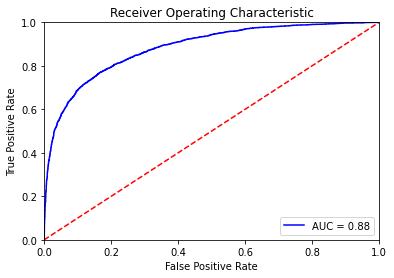

In [10]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(t1, s1.view(-1))
roc_auc = metrics.auc(fpr, tpr)
log_dict['fpr'] = fpr
log_dict['tpr'] = tpr
log_dict['threshold'] = threshold


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

tn, fp, fn, tp = conf_mat.ravel()
print(f'sensitivity: {tp/(tp+fn)}')
print(f'specificity: {tn/(tn+fp)}')

In [20]:
print(len(log_dict['fpr']))
rate_idx = 1450
print(log_dict['fpr'][rate_idx])
print(log_dict['tpr'][rate_idx])
print(log_dict['threshold'][rate_idx])

2602
0.2150805270863836
0.8087357569180683
0.2773313


## Analyze Stage Two
Set the desired threshold based on AUC

In [47]:
masks, preds, targets = [], [], []
for fold in range(CFG.nfolds):
    model_fd1 = log_dict[f'stage1_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    model_fd2 = log_dict[f'stage2_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    _, loader_val = data_loader_stage2(fold)
    for inputs, labels in tqdm(loader_val):
        _, C, H, W = inputs[0].shape
        # n_tile[(bs,3,128,128)]-->(bs,n_tile,3,128,128)-->(bs*n_tile,3,128,128)
        inputs = torch.stack(inputs, 1).view(-1,C,H,W).to(device=CFG.device, dtype=CFG.dtype)
                
        # Forward, track history if only in training
        with torch.no_grad():
            probs = model_fd1(inputs).squeeze()
            outputs = model_fd2(inputs)
            # https://github.com/Cysu/open-reid/issues/69
            # torch.cat can't concatenate scalar value. So we use torch.tensor([0]) here
            mask = torch.where(probs<CFG1.threshold,
                               torch.tensor([0]).to(device=CFG.device),
                               torch.tensor([1]).to(device=CFG.device))
            pred = torch.argmax(outputs, 1)
        masks.append(mask)
        targets.append(labels)
        preds.append(pred)

Kappa: 0.3188546767345404


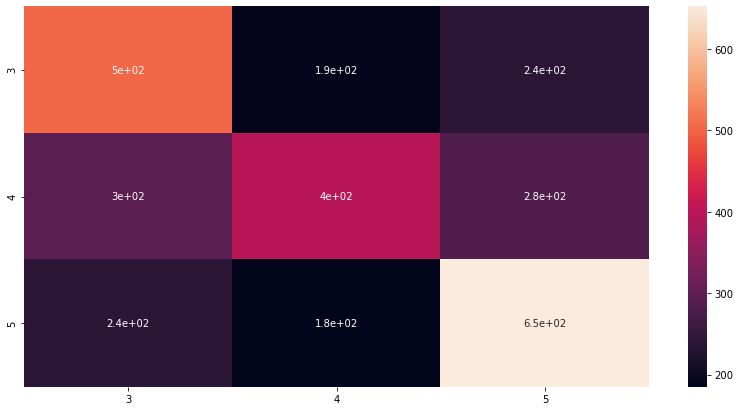

In [49]:
p2 = torch.cat(preds).cpu()
t2 = torch.cat(targets).cpu()
m2 = torch.cat(masks).cpu()

kappa = cohen_kappa_score(t2[m2==1], p2[m2==1], weights='quadratic')
print(f'Kappa: {kappa}')
conf_mat = confusion_matrix(t2[m2==1], p2[m2==1])
#plt.matshow()
plt.figure(figsize=(14,7))
isup_labels = list(range(3,6))
sn.heatmap(conf_mat, annot=True, xticklabels=isup_labels, yticklabels=isup_labels)